# Disaster Classification

## Imports & Function

In [3]:
!unzip /content/drive/MyDrive/Unlimited/Datasets/twitter_disaster/twitter.zip

Archive:  /content/drive/MyDrive/Unlimited/Datasets/twitter_disaster/twitter.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [98]:
import tensorflow as tf
import numpy as np
import pandas as pd

import re
import string
import os
import json
import itertools

import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import WordCloud

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.utils import class_weight

from tensorflow.keras.layers import Dense,Embedding,LSTM,SpatialDropout1D,Dropout,Conv1D,MaxPool1D,GlobalMaxPooling1D,BatchNormalization
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau

from bs4 import BeautifulSoup
import unicodedata

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
# from imblearn.over_sampling import SMOTE

from ktrain import text
import ktrain

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
nltk.download('stopwords')
nltk.download('punkt')

stop_words = set(stopwords.words('english'))
 
def rem_stop_words_with_stemming(x):  
  word_tokens = word_tokenize(x)
  
  # filtered_sentence = [w for w in word_tokens if not w.lower() in stop_words]
  
  filtered_sentence = []
  
  for w in word_tokens:
      if w not in stop_words:
          filtered_sentence.append(w)
  ps = nltk.PorterStemmer()
  filtered_sentence = [ps.stem(word) for word in filtered_sentence]
  filtered_sentence=" ".join(filtered_sentence)
  return filtered_sentence

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [5]:
def expression(x):
	abbreviations =json.load(open("/content/drive/MyDrive/Unlimited/Datasets/abrreviations.json"))

	if type(x) is str:
		for key in abbreviations:
			value = abbreviations[key]
			raw_text = r'\b' + key + r'\b'
			x = re.sub(raw_text, value, x)
			# print(raw_text,value, x)
		return x
	else:
		return x


def remove_special_chars(x):
	x = re.sub(r'[^\w ]+', "", x)
	x = ' '.join(x.split())
	return x

In [6]:
def clean_data(x):
  x = re.sub(r'(http|https|httpt|ftp|ssh)://([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?', '' , x)
  x = expression(x)
  x = str(x).lower().replace("\\"," ").replace('_'," ").replace("."," ")
  x = re.sub(r'([a-z0-9+._-]+@[a-z0-9+._-]+\.[a-z0-9+_-]+)',"", x)
  x = BeautifulSoup(x, 'lxml').get_text().strip()
  x = re.sub(r'\brt\b', '', x).strip()
  x = remove_special_chars(x)
  x = re.sub("httpt","",x)
  x = unicodedata.normalize('NFKD', x).encode('ascii', 'ignore').decode('utf-8', 'ignore')
  x = re.sub("(.)\\1{2,}", "\\1", x)
  return x


## Preprocessing and Visualisation

In [7]:
df=pd.read_csv("/content/train.csv")

In [8]:
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


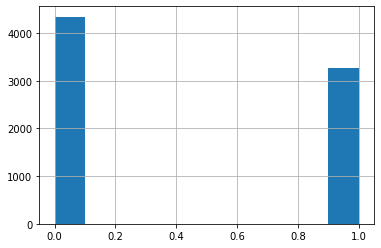

In [9]:
df["target"].hist()

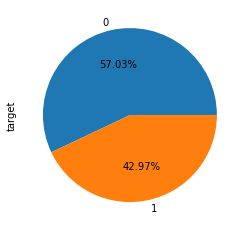

In [10]:
df["target"].value_counts().plot.pie(autopct="%1.2f%%")

In [11]:
df["text"][0]

'Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all'

### Visualising Character and Word distribution


In [12]:
df["word_count"]=df["text"].apply(lambda x: len(str(x).split()))
df["char_count"]=df["text"].apply(lambda x: len("".join(x.split())))

In [13]:
df.head()

,id,keyword,location,text,target,word_count,char_count
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,13,57
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,7,32
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,22,112
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,8,57
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,16,72


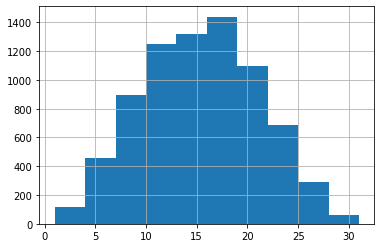

In [14]:
df["word_count"].hist()

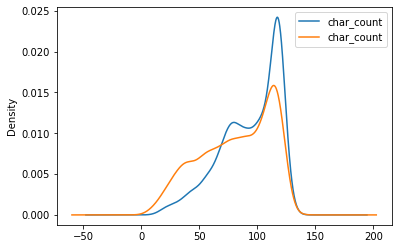

In [15]:
df[df["target"]==1]["char_count"].plot(kind="kde",legend=True)
df[df["target"]==0]["char_count"].plot(kind="kde",legend=True)


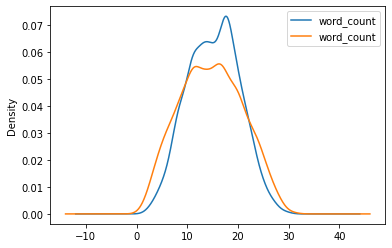

In [16]:
df[df["target"]==1]["word_count"].plot(kind="kde",legend=True)
df[df["target"]==0]["word_count"].plot(kind="kde",legend=True)


### Data cleaning

In [17]:
df["text"]=df["text"].apply(lambda x: clean_data(x))

In [18]:
df.head()

,id,keyword,location,text,target,word_count,char_count
0,1,NaN,NaN,our deeds are the reason of this earthquake ma...,1,13,57
1,4,NaN,NaN,forest fire near la ronge sask canada,1,7,32
2,5,NaN,NaN,all residents asked to shelter in place are be...,1,22,112
3,6,NaN,NaN,130 people receive wildfires evacuation orders...,1,8,57
4,7,NaN,NaN,just got sent this photo from ruby alaska as s...,1,16,72


In [19]:
df["text"][0]

'our deeds are the reason of this earthquake may allah forgive us all'

In [20]:
rem_stop_words_with_stemming(df['text'][0])

'deed reason earthquak may allah forgiv us'

In [21]:
df["filtered_text"]=df["text"].apply(lambda x: rem_stop_words_with_stemming(x))

In [22]:
df.head()

,id,keyword,location,text,target,word_count,char_count,filtered_text
0,1,NaN,NaN,our deeds are the reason of this earthquake ma...,1,13,57,deed reason earthquak may allah forgiv us
1,4,NaN,NaN,forest fire near la ronge sask canada,1,7,32,forest fire near la rong sask canada
2,5,NaN,NaN,all residents asked to shelter in place are be...,1,22,112,resid ask shelter place notifi offic evacu she...
3,6,NaN,NaN,130 people receive wildfires evacuation orders...,1,8,57,130 peopl receiv wildfir evacu order california
4,7,NaN,NaN,just got sent this photo from ruby alaska as s...,1,16,72,got sent photo rubi alaska smoke wildfir pour ...


In [23]:
real_word=[i for i in df[df["target"]==1]["filtered_text"]]
real_corpus=" ".join(real_word)
real_corpus[:200]

'deed reason earthquak may allah forgiv us forest fire near la rong sask canada resid ask shelter place notifi offic evacu shelter place order expect 130 peopl receiv wildfir evacu order california got'

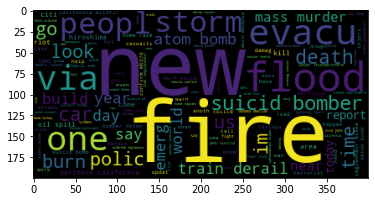

In [24]:
word_cloud=WordCloud(max_font_size=100).generate(real_corpus)
plt.imshow(word_cloud)
plt.show()


In [25]:
fake_word=[i for i in df[df["target"]==0]["filtered_text"]]
fake_corpus=" ".join(fake_word)
fake_corpus[:200]

'what man love fruit summer love car fast goal ridicul london cool love ski wonder day lol way eat shit nyc last week love girlfriend col like pasta end alway tri bring heavi metal cri set ablaz plu si'

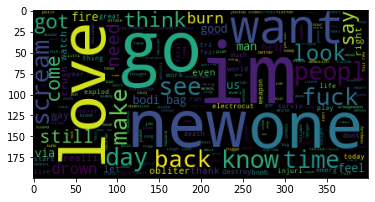

In [26]:
word_cloud=WordCloud(max_font_size=100).generate(fake_corpus)
plt.imshow(word_cloud)
plt.show()


## Classification with TFIDF and SVM

In [27]:
text = df["filtered_text"]
y = df["target"]

In [28]:
tfidf=TfidfVectorizer()
X=tfidf.fit_transform(text)

In [29]:
X.shape

(7613, 14810)

In [30]:
train_ratio = 0.70
validation_ratio = 0.15
test_ratio = 0.15


In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1 - train_ratio,stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test,stratify=y_test,test_size=test_ratio/(test_ratio + validation_ratio)) 

In [32]:
print('X_train shape :', X_train.shape,'X_val shape :', X_val.shape, 'X_test shape: ',X_test.shape)

X_train shape : (5329, 14810) X_val shape : (1142, 14810) X_test shape:  (1142, 14810)


In [33]:
X_train

<5329x14810 sparse matrix of type '<class 'numpy.float64'>'
	with 47640 stored elements in Compressed Sparse Row format>

In [34]:
y_train.unique()

array([1, 0])

In [35]:
class_weights = class_weight.compute_class_weight('balanced',[0,1],y_train)
class_weights

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0, 1], y=7331    1
1096    1
6069    1
1567    1
3428    0
       ..
1139    1
63      1
1756    1
3989    1
3463    0
Name: target, Length: 5329, dtype: int64 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


array([0.87676867, 1.16353712])

In [36]:
class_weight_dict = dict(enumerate(class_weights))
class_weight_dict

{0: 0.8767686739058901, 1: 1.1635371179039302}

In [37]:
from sklearn.svm import LinearSVC
classifier=LinearSVC(class_weight=class_weight_dict)

In [38]:
classifier.fit(X_train,y_train)

LinearSVC(class_weight={0: 0.8767686739058901, 1: 1.1635371179039302})

In [39]:
y_pred=classifier.predict(X_test)

In [40]:
class_label={0:"Fake",1:"Real"}

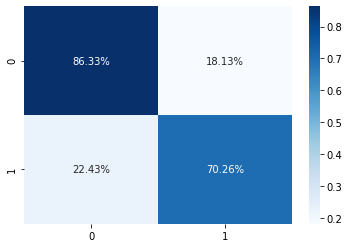

In [41]:
cnf_mat=confusion_matrix(y_test,y_pred)
sns.heatmap(cnf_mat/np.sum(cnf_mat,axis=1),cmap='Blues',annot=True,fmt='.2%')

In [42]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.79      0.86      0.83       651
           1       0.79      0.70      0.75       491

    accuracy                           0.79      1142
   macro avg       0.79      0.78      0.79      1142
weighted avg       0.79      0.79      0.79      1142



## Classification with DL

In [43]:
token = Tokenizer()
token.fit_on_texts(df["filtered_text"])

In [44]:
token.index_word.items()

dict_items([(1, 'like'), (2, 'fire'), (3, 'get'), (4, 'im'), (5, 'bomb'), (6, 'new'), (7, 'via'), (8, 'peopl'), (9, 'one'), (10, 'go'), (11, '2'), (12, 'news'), (13, 'burn'), (14, 'kill'), (15, 'video'), (16, 'flood'), (17, 'time'), (18, 'emerg'), (19, 'crash'), (20, 'disast'), (21, 'would'), (22, 'attack'), (23, 'bodi'), (24, 'build'), (25, 'year'), (26, 'u'), (27, 'look'), (28, 'say'), (29, 'polic'), (30, 'fatal'), (31, 'home'), (32, 'day'), (33, 'love'), (34, 'us'), (35, 'famili'), (36, 'make'), (37, 'evacu'), (38, 'train'), (39, 'still'), (40, 'see'), (41, 'come'), (42, 'know'), (43, 'got'), (44, 'back'), (45, 'storm'), (46, 'california'), (47, 'live'), (48, 'want'), (49, 'watch'), (50, 'suicid'), (51, '3'), (52, 'world'), (53, 'collaps'), (54, 'scream'), (55, 'bag'), (56, 'derail'), (57, 'car'), (58, 'man'), (59, 'death'), (60, 'first'), (61, 'take'), (62, 'think'), (63, 'caus'), (64, 'work'), (65, 'today'), (66, 'fuck'), (67, 'need'), (68, 'nuclear'), (69, 'drown'), (70, 'wreck')

In [45]:
vocab_size=len(token.word_index)+1
vocab_size

14839

In [46]:
enc_text=token.texts_to_sequences(df["filtered_text"])

In [47]:
enc_text[0]

[3834, 488, 216, 88, 1525, 3012, 34]

In [48]:
MAX_LEN=40
X=pad_sequences(enc_text,maxlen=MAX_LEN,padding="post")

In [49]:
y=df["target"]

In [50]:
X.shape,y.shape

((7613, 40), (7613,))

In [51]:
# smote =SMOTE()
# X, y = smote.fit_resample(X, y)

In [52]:
# X.shape,y.shape

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1 - train_ratio,stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test,stratify=y_test,test_size=test_ratio/(test_ratio + validation_ratio)) 
print('X_train shape :', X_train.shape,'X_val shape :', X_val.shape, 'X_test shape: ',X_test.shape)

X_train shape : (5329, 40) X_val shape : (1142, 40) X_test shape:  (1142, 40)


In [54]:
emb_dim=500

In [55]:
model=tf.keras.models.Sequential([
                                  Embedding(vocab_size,emb_dim,input_length=MAX_LEN),
                                  Conv1D(4096,2,2,activation='relu'),
                                  BatchNormalization(),
                                  Dropout(0.2),

                                  Conv1D(2048,2,2,activation='relu'),
                                  BatchNormalization(),
                                  Dropout(0.2),

                                  Conv1D(1024,2,2,activation='relu'),
                                  BatchNormalization(),
                                  Dropout(0.2),

                                  Conv1D(512,2,2,activation='relu'),
                                  BatchNormalization(),
                                  Dropout(0.2),

                                  Conv1D(256,2,2,activation='relu'),
                                  BatchNormalization(),
                                  Dropout(0.2),

                                  Dense(128,activation='relu'),
                                  BatchNormalization(),
                                  Dropout(0.2),

                                  Dense(64,activation='relu'),
                                  BatchNormalization(),
                                  Dropout(0.2),

                                  Dense(32,activation='relu'),
                                  BatchNormalization(),
                                  Dropout(0.2),

                                  Dense(16,activation='relu'),
                                  
                                  GlobalMaxPooling1D(),

                                  Dense(1,activation="sigmoid")



])

In [56]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 40, 500)           7419500   
_________________________________________________________________
conv1d (Conv1D)              (None, 20, 4096)          4100096   
_________________________________________________________________
batch_normalization (BatchNo (None, 20, 4096)          16384     
_________________________________________________________________
dropout (Dropout)            (None, 20, 4096)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 10, 2048)          16779264  
_________________________________________________________________
batch_normalization_1 (Batch (None, 10, 2048)          8192      
_________________________________________________________________
dropout_1 (Dropout)          (None, 10, 2048)          0

In [57]:
model.compile(optimizer="adam",metrics=["accuracy"],loss="binary_crossentropy")

In [58]:
checkpoint=ModelCheckpoint("./content/trained_model/tweet_detect_cnn.hd5",monitor="val_loss",mode="min",
                           save_best_only=True,verbose=1)

earlystop=EarlyStopping(monitor="val_loss",min_delta=0,patience=6,verbose=1,restore_best_weights=True)

reduce_lr=ReduceLROnPlateau(monitor="val_loss",factor=0.2,patience=2,verbose=1,min_delta=0.0001)

callbacks=[checkpoint,earlystop,reduce_lr]

In [59]:
class_weights = class_weight.compute_class_weight('balanced',[0,1],y_train)
class_weights

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0, 1], y=2005    1
1513    0
7210    0
3680    0
7259    0
       ..
6657    1
2239    1
1106    0
2022    1
7354    1
Name: target, Length: 5329, dtype: int64 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


array([0.87676867, 1.16353712])

In [60]:
y_train.unique()

array([1, 0])

In [61]:
# !rm -r '/content/content'

In [62]:
class_weight_dict = dict(enumerate(class_weights))
class_weight_dict

{0: 0.8767686739058901, 1: 1.1635371179039302}

In [63]:
epochs=50
history=model.fit(X_train,y_train,class_weight=class_weight_dict,
                            epochs=epochs,callbacks=callbacks,
                            validation_data=(X_val,y_val))

Epoch 1/50
167/167 [==============================] - 33s 166ms/step - loss: 0.7289 - accuracy: 0.5410 - val_loss: 0.6980 - val_accuracy: 0.5105

Epoch 00001: val_loss improved from inf to 0.69796, saving model to ./content/trained_model/tweet_detect_cnn.hd5
INFO:tensorflow:Assets written to: ./content/trained_model/tweet_detect_cnn.hd5/assets
Epoch 2/50
167/167 [==============================] - 27s 160ms/step - loss: 0.7000 - accuracy: 0.5299 - val_loss: 0.7077 - val_accuracy: 0.4545

Epoch 00002: val_loss did not improve from 0.69796
Epoch 3/50
167/167 [==============================] - 27s 160ms/step - loss: 0.5898 - accuracy: 0.6913 - val_loss: 0.6995 - val_accuracy: 0.5744

Epoch 00003: val_loss did not improve from 0.69796

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
Epoch 4/50
167/167 [==============================] - 27s 160ms/step - loss: 0.3982 - accuracy: 0.8459 - val_loss: 0.5740 - val_accuracy: 0.7426

Epoch 00004: val_loss improved f

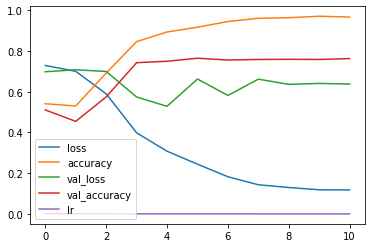

In [64]:
pd.DataFrame(history.history).plot()

In [65]:
y_pred_test=np.round(model.predict(X_test))
y_pred_val=np.round(model.predict(X_val))

In [66]:
print(" Classification report for Validation set ")
print(classification_report(y_val,y_pred_val))

 Classification report for Validation set 
              precision    recall  f1-score   support

           0       0.76      0.83      0.79       652
           1       0.74      0.65      0.69       490

    accuracy                           0.75      1142
   macro avg       0.75      0.74      0.74      1142
weighted avg       0.75      0.75      0.75      1142



In [67]:
print(" Classification report for test set ")
print(classification_report(y_test,y_pred_test))

 Classification report for test set 
              precision    recall  f1-score   support

           0       0.78      0.85      0.81       651
           1       0.78      0.67      0.72       491

    accuracy                           0.78      1142
   macro avg       0.78      0.76      0.77      1142
weighted avg       0.78      0.78      0.77      1142



In [68]:
list(class_label.values())

['Fake', 'Real']

In [69]:
cnf_mat=confusion_matrix(y_test,y_pred_test)

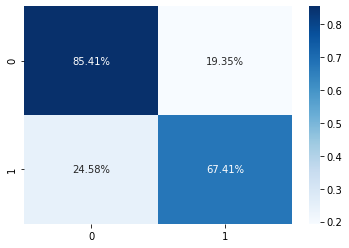

In [70]:
sns.heatmap(cnf_mat/np.sum(cnf_mat,axis=1),cmap='Blues',annot=True,fmt='.2%')

## With LSTMs

In [71]:
model_lstm=tf.keras.models.Sequential([
                                  tf.keras.layers.Input((MAX_LEN,)),
                                  Embedding(vocab_size,emb_dim),
                                  LSTM(512,return_sequences=True),
                                  BatchNormalization(),
                                  Dropout(0.2),
                                  LSTM(256,return_sequences=True),
                                  BatchNormalization(),
                                  Dropout(0.2),
                                  LSTM(128,return_sequences=True),
                                  BatchNormalization(),
                                  Dropout(0.2),
                                  LSTM(64,return_sequences=True),
                                  tf.keras.layers.GlobalAveragePooling1D(),

                                  Dense(32,activation='relu'),
                                  BatchNormalization(),

                                  Dense(16,activation='relu'),

                                  Dense(1,activation="sigmoid")
])

In [72]:
model_lstm.compile(loss="binary_crossentropy",optimizer="adam",metrics=["accuracy"])

In [73]:
checkpoint=ModelCheckpoint("./content/trained_model/tweet_detect_lstm.hd5",monitor="val_loss",mode="min",
                           save_best_only=True,verbose=1)

earlystop=EarlyStopping(monitor="val_loss",min_delta=0,patience=6,verbose=1,restore_best_weights=True)

reduce_lr=ReduceLROnPlateau(monitor="val_loss",factor=0.2,patience=2,verbose=1,min_delta=0.0001)

callbacks=[checkpoint,earlystop,reduce_lr]

In [74]:
epochs=50
history=model_lstm.fit(X_train,y_train,class_weight=class_weight_dict,
                            epochs=epochs,callbacks=callbacks,
                            validation_data=(X_val,y_val)
                            )

Epoch 1/50
167/167 [==============================] - 22s 83ms/step - loss: 0.5823 - accuracy: 0.6849 - val_loss: 0.6369 - val_accuracy: 0.7215

Epoch 00001: val_loss improved from inf to 0.63689, saving model to ./content/trained_model/tweet_detect_lstm.hd5


INFO:tensorflow:Assets written to: ./content/trained_model/tweet_detect_lstm.hd5/assets


INFO:tensorflow:Assets written to: ./content/trained_model/tweet_detect_lstm.hd5/assets


Epoch 2/50
167/167 [==============================] - 12s 73ms/step - loss: 0.3355 - accuracy: 0.8673 - val_loss: 0.6054 - val_accuracy: 0.7215

Epoch 00002: val_loss improved from 0.63689 to 0.60537, saving model to ./content/trained_model/tweet_detect_lstm.hd5


INFO:tensorflow:Assets written to: ./content/trained_model/tweet_detect_lstm.hd5/assets


INFO:tensorflow:Assets written to: ./content/trained_model/tweet_detect_lstm.hd5/assets


Epoch 3/50
167/167 [==============================] - 12s 74ms/step - loss: 0.1902 - accuracy: 0.9338 - val_loss: 0.5060 - val_accuracy: 0.7531

Epoch 00003: val_loss improved from 0.60537 to 0.50596, saving model to ./content/trained_model/tweet_detect_lstm.hd5


INFO:tensorflow:Assets written to: ./content/trained_model/tweet_detect_lstm.hd5/assets


INFO:tensorflow:Assets written to: ./content/trained_model/tweet_detect_lstm.hd5/assets


Epoch 4/50
167/167 [==============================] - 12s 74ms/step - loss: 0.1499 - accuracy: 0.9516 - val_loss: 3.2717 - val_accuracy: 0.4291

Epoch 00004: val_loss did not improve from 0.50596
Epoch 5/50
167/167 [==============================] - 12s 73ms/step - loss: 0.1122 - accuracy: 0.9647 - val_loss: 0.7120 - val_accuracy: 0.7592

Epoch 00005: val_loss did not improve from 0.50596

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
Epoch 6/50
167/167 [==============================] - 12s 73ms/step - loss: 0.0660 - accuracy: 0.9803 - val_loss: 0.8682 - val_accuracy: 0.7531

Epoch 00006: val_loss did not improve from 0.50596
Epoch 7/50
167/167 [==============================] - 12s 73ms/step - loss: 0.0499 - accuracy: 0.9827 - val_loss: 1.0465 - val_accuracy: 0.7539

Epoch 00007: val_loss did not improve from 0.50596

Epoch 00007: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.
Epoch 8/50
167/167 [==============================] 

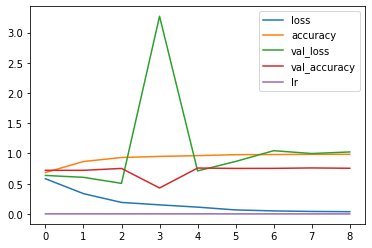

In [75]:
pd.DataFrame(history.history).plot()

In [76]:
y_pred_test=np.round(model_lstm.predict(X_test))
y_pred_val=np.round(model_lstm.predict(X_val))

In [77]:
print(" Classification report for Validation set ")
print(classification_report(y_val,y_pred_val))

 Classification report for Validation set 
              precision    recall  f1-score   support

           0       0.77      0.81      0.79       652
           1       0.73      0.68      0.70       490

    accuracy                           0.75      1142
   macro avg       0.75      0.74      0.75      1142
weighted avg       0.75      0.75      0.75      1142



In [78]:
print(" Classification report for test set ")
print(classification_report(y_test,y_pred_test))

 Classification report for test set 
              precision    recall  f1-score   support

           0       0.78      0.86      0.82       651
           1       0.78      0.67      0.72       491

    accuracy                           0.78      1142
   macro avg       0.78      0.77      0.77      1142
weighted avg       0.78      0.78      0.78      1142



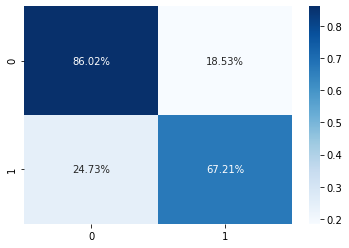

In [79]:
cnf_matrix=confusion_matrix(y_test,y_pred_test)
sns.heatmap(cnf_matrix/np.sum(cnf_matrix,axis=1),annot=True,fmt='.2%',cmap='Blues')

## BERT


In [ ]:
!pip install ktrain

In [104]:
df_bert=pd.read_csv("/content/train.csv")

In [105]:
df_bert.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [106]:
train_ratio = 0.80

In [107]:
df_train, df_test = train_test_split(df_bert, test_size=(1 - train_ratio),stratify=df_bert['target'])

In [108]:
(X_train, y_train), (X_test, y_test), preproc = text.texts_from_df(train_df=df_train,
                                                                   text_column = 'text',
                                                                   label_columns = 'target',
                                                                   val_df = df_test,
                                                                   maxlen = 40,
                                                                   preprocess_mode = 'bert')

['not_target', 'target']
      not_target  target
7383         1.0     0.0
7481         0.0     1.0
4190         1.0     0.0
4641         1.0     0.0
6804         1.0     0.0
['not_target', 'target']
      not_target  target
4122         0.0     1.0
5749         1.0     0.0
1577         1.0     0.0
4564         1.0     0.0
2053         1.0     0.0
preprocessing train...
language: en


Is Multi-Label? False
preprocessing test...
language: en


In [147]:
model = text.text_classifier(name = 'bert',
                             train_data = (X_train, y_train),
                             preproc = preproc)

Is Multi-Label? False
maxlen is 40
done.


In [148]:
learner = ktrain.get_learner(model=model, train_data=(X_train, y_train),
                   val_data = (X_test, y_test))

In [149]:
class_weights = class_weight.compute_class_weight('balanced',[0,1],y_train[:,1])
class_weights

array([0.8767636 , 1.16354605])

In [ ]:

# learner.lr_find(max_epochs=10,class_weight=dict(enumerate(class_weights)))
# learner.lr_plot()


In [152]:
learner.fit_onecycle(lr = 2e-4, epochs = 1)



begin training using onecycle policy with max lr of 0.0002...
191/191 [==============================] - 116s 610ms/step - loss: 0.3902 - accuracy: 0.8386 - val_loss: 0.4130 - val_accuracy: 0.8194


In [153]:
predictor = ktrain.get_predictor(learner.model, preproc)

In [154]:
y_pred_probs=predictor.predict(list(df_test['text']))
y_pred=[1 if i=='target' else 0 for i in y_pred_probs]

In [155]:
y_true=list(df_test.target)

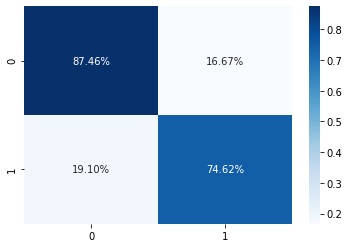

In [156]:
cnf_mat=confusion_matrix(y_true,y_pred)
sns.heatmap(cnf_mat/np.sum(cnf_mat,axis=1),cmap='Blues',fmt='.2%',annot=True)

In [157]:
predictor.save('/content/content/trained_model/bert')

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [158]:
!zip -r /content/drive/MyDrive/Unlimited/Datasets/twitter_disaster/model.zip /content/content/trained_model


updating: content/content/trained_model/ (stored 0%)
updating: content/content/trained_model/tweet_detect_cnn.hd5/ (stored 0%)
updating: content/content/trained_model/tweet_detect_cnn.hd5/keras_metadata.pb (deflated 94%)
updating: content/content/trained_model/tweet_detect_cnn.hd5/assets/ (stored 0%)
updating: content/content/trained_model/tweet_detect_cnn.hd5/saved_model.pb (deflated 90%)
updating: content/content/trained_model/tweet_detect_cnn.hd5/variables/ (stored 0%)
updating: content/content/trained_model/tweet_detect_cnn.hd5/variables/variables.index (deflated 74%)
updating: content/content/trained_model/tweet_detect_cnn.hd5/variables/variables.data-00000-of-00001 (deflated 10%)
updating: content/content/trained_model/tweet_detect_lstm.hd5/ (stored 0%)
updating: content/content/trained_model/tweet_detect_lstm.hd5/keras_metadata.pb (deflated 93%)
updating: content/content/trained_model/tweet_detect_lstm.hd5/assets/ (stored 0%)
updating: content/content/trained_model/tweet_detect_

### Self Evaluation

In [167]:
def get_enc(x):
  x = clean_data(x)
  x = rem_stop_words_with_stemming(x)
  x = token.texts_to_sequences([x])
  x = pad_sequences(x,maxlen=MAX_LEN,padding="post")
  return x

In [168]:
MAX_LEN

40

In [169]:
x ="wtf...This is a horrible earthquake. SOS send help fast"

In [170]:
vec=get_enc(x)

In [171]:
vec.shape

(1, 40)

In [173]:
model_lstm.predict(vec)

array([[0.5213182]], dtype=float32)

In [174]:
predictor.predict(x)

'target'

In [175]:
df_test=pd.read_csv("/content/test.csv")

In [176]:
df_test["text"]=df_test["text"].apply(lambda x: clean_data(x))

In [177]:
df_test["filtered_text"]=df_test["text"].apply(lambda x: rem_stop_words_with_stemming(x))

In [178]:
df_test.head()

,id,keyword,location,text,filtered_text
0,0,NaN,NaN,just happened a terrible car crash,happen terribl car crash
1,2,NaN,NaN,heard about earthquake is different cities sta...,heard earthquak differ citi stay safe everyon
2,3,NaN,NaN,there is a forest fire at spot pond geese are ...,forest fire spot pond gees flee across street ...
3,9,NaN,NaN,apocalypse lighting spokane wildfires,apocalyps light spokan wildfir
4,11,NaN,NaN,typhoon soudelor kills 28 in china and taiwan,typhoon soudelor kill 28 china taiwan


In [179]:
test_seq=pad_sequences(token.texts_to_sequences(df_test["filtered_text"]),maxlen=MAX_LEN,padding="post")

In [181]:
y_pred_probs=model_lstm.predict(test_seq)

In [182]:
y_pred=np.round(y_pred_probs).astype("int")
y_pred

array([[1],
       [0],
       [1],
       ...,
       [1],
       [1],
       [1]])

In [183]:
np.unique(y_pred,return_counts=True)

(array([0, 1]), array([2038, 1225]))

In [184]:
y_pred

array([[1],
       [0],
       [1],
       ...,
       [1],
       [1],
       [1]])

In [185]:
y_pred=pd.DataFrame(y_pred)